In [28]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

In [29]:
def calc_price(phi1, phi2, cost, wtp):
    """compute each insurer's price (assumes interior solution)"""
    phi1, phi2 = phi1, phi2
    p1 = (2*phi1+phi2)/3. + cost
    p2 = (2*phi2+phi1)/3. + cost
    if phi1 <= 0 or phi2 <= 0:
        return 0,0
    
    return p1, p2
  
    
def calc_s(phi1, phi2, cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    p1, p2 = calc_price(phi1, phi2, cost, wtp)
    s_hat = .5 + (p2 - p1)/(2.*cost)
    return s_hat


def calc_profits(phi1,phi2,cost, wtp, mc):
    phi1, phi2 = phi1, phi2
    s= calc_s(phi1, phi2, cost, wtp)
    p1,p2 = calc_price(phi1, phi2, cost, wtp)
    profits1, profits2 = s*(p1-phi1), (1-s)*(p2-phi2)
    mc1,mc2 = mc
    hosp_profit = s*(phi1-mc1) +  (1-s)*(phi2-mc2)
    
    if phi1 <= 0 or phi2 <= 0:
        return 0,0,0
    
    return hosp_profit, profits1, profits2

    
def outside_simlt(phi1, phi2, cost, wtp,  mc):
    """outside option in simult case
    assuming listprice high enough"""
    mc1,mc2 = mc
    
    s_hat = calc_s(phi1, phi2, cost, wtp) # s_hat with no recapture
    p1,p2 = calc_price(phi1, phi2, cost, wtp)
    #s_hat  = np.clip((cost + p2 - wtp)/cost,0,1) #s_hat with recapture
    
    return (1-s_hat)*(phi2 -mc2)


calc_profits(5,0 ,5, 26, [0,0])

(0, 0, 0)

In [30]:
#arbitrary outside option...
def nash_in_nash(phi1, phi2, cost, wtp, mc, beta=.5,outside=None):
    if outside == None:
        outside = outside_simlt(phi1, phi2,cost, wtp , mc)

    hosp_profit, profits1, profits2 = calc_profits(phi1, phi2,  cost,  wtp, mc)
    obj = -1*(np.log(max(hosp_profit-outside,1e-4))*(1-beta) 
              + np.log(profits1)*beta)
    return obj

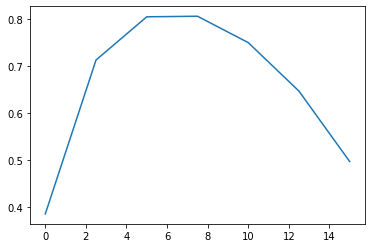

In [31]:
COST = 5
WTP = 25
MC = np.array([0,0])

plt.plot([i for i in np.linspace(0,3*COST,num=7)], 
         [-1*nash_in_nash(i, 4, COST,WTP,MC) for i in np.linspace(1,2*COST,num=7)])

In [32]:
def bargain_helper(phi1, phi2, cost, wtp, mc, beta=.5,outside=None):
    """solve each firm 1s optimization holding phi 2 fixed"""
    result = minimize(nash_in_nash, phi1, args=(phi2,cost, wtp, mc, beta, outside),
                      method='Nelder-Mead', options={'disp': False})
    return result.x

COST = 5
WTP  = 10
MC = np.array([0,0])

print(bargain_helper(15,15, COST,WTP,MC,beta=.5))

[7.5]


In [35]:
def simult_bargain(phi1, phi2, cost, wtp, mc, betas=[.5,.5]):
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables, check on this...
    diff =  np.maximum(phi1,phi2)
    phi10,phi20 = 0,0
    maxiter = 10
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        
        outside1 = outside_simlt(phi10, phi20, cost, wtp,  mc)
        outside2 = outside_simlt(phi20, phi10, cost, wtp, mc[::-1])
        phi1 = bargain_helper(phi1, phi2, cost, wtp, mc, beta=betas[0],outside=outside1)
        phi2 = bargain_helper(phi2, phi1, cost, wtp, mc[::-1], beta=betas[1],outside=outside2)
        
        #update loop variables
        diff = np.abs(np.maximum(phi1 - phi10,phi2-phi20))[0]
        print(phi1,phi10,phi2,phi20)
        phi10,phi20 = phi1,phi2
        maxiter = maxiter-1
        
    return phi1, phi2

COST = 7
WTP  = 25
MC = np.array([0,0])
print(simult_bargain(2,2,COST,WTP,MC))
#print(simult_bargain(15,15,COST,WTP,MC,active=True))

[4.92617188] 0 [5.18789063] 0
[7.4884788] [4.92617188] [7.69431561] [5.18789063]
[8.8360759] [7.4884788] [8.99291922] [7.69431561]
[9.58210519] [8.8360759] [9.67759741] [8.99291922]
[9.99272507] [9.58210519] [10.04895395] [9.67759741]
[10.21973265] [9.99272507] [10.25178531] [10.04895395]
[10.34517139] [10.21973265] [10.36316335] [10.25178531]
[10.41443807] [10.34517139] [10.42451753] [10.36316335]
[10.45276757] [10.41443807] [10.45830304] [10.42451753]
[10.47388492] [10.45276757] [10.47700594] [10.45830304]
[10.48558365] [10.47388492] [10.48730134] [10.47700594]
(array([10.48558365]), array([10.48730134]))
